The purpose of this notebook is to develop architecture and utilities for fit neural network on B → J reconstruction problem.

In [19]:
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format='retina'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [20]:
from IPython.display import display, clear_output

In [21]:
import sys
sys.path.append('../../..')

In [22]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt

from magrec.prop.Fourier import FourierTransform2d
from magrec.prop.Kernel import HarmonicFunctionComponentsKernel, MagneticFieldToCurrentInversion2d
from magrec.prop.Propagator import CurrentPropagator2d, AxisProjectionPropagator
from magrec.misc.plot import plot_n_components
from magrec.nn.arch import GeneratorCNN
from magrec import __datapath__

In [23]:
from magrec.misc.load import load_matlab_data

Loaded data of shape (4, 125, 55), padded up to torch.Size([4, 125, 55]), with spacing dx = 0.020 μm, dy = 0.029 μm


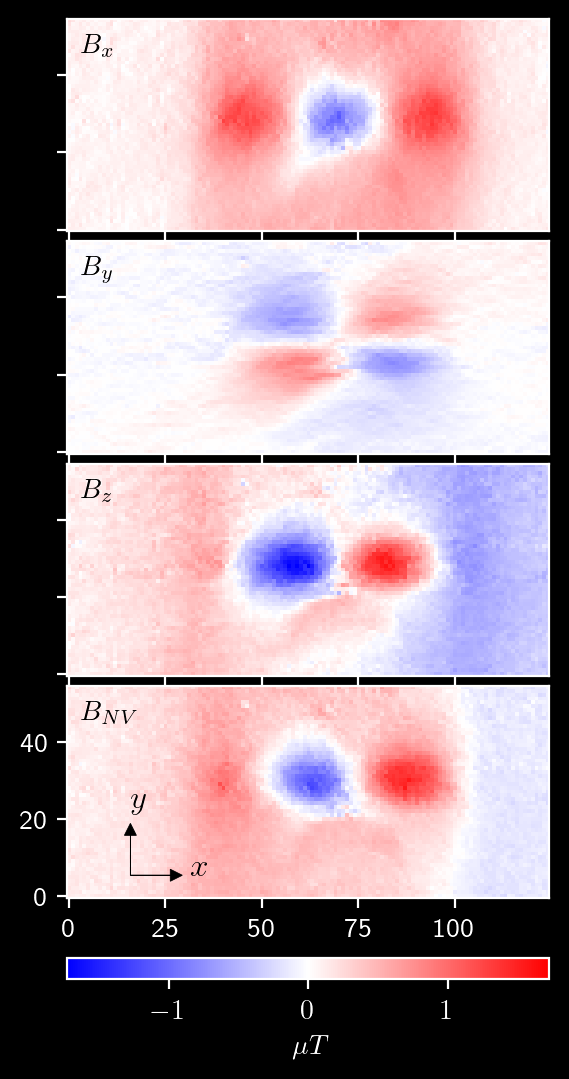

In [24]:
mat = load_matlab_data(__datapath__ / "ExperimentalData" / "Harvard" / "XY_Bnv_Bxyz_Jxy_SChenJJ_data2.mat")

Bx = mat['BX_map'].T
By = mat['BY_map'].T
Bz = mat['BZ_map'].T
Bnv = mat['Bnv_map'].T

B = np.stack((Bx, By, Bz, Bnv), axis=0)
original_shape = B.shape

# make roi slice obejct out of the original shape, assuming the data starts at (0, 0)
roi_original = (slice(None), slice(original_shape[-2]), slice(original_shape[-1]))

B = B * 1e6 # convert to μT

B = torch.tensor(B, dtype=torch.float32)

# find mean spacing between points, assuming uniform (more or less) grid
dx = np.diff(mat['rx_inv']).mean()
dy = np.diff(mat['ry_inv']).mean()

print(f'Loaded data of shape {original_shape}, padded up to {B.shape}, with spacing dx = {dx:.3f} μm, dy = {dy:.3f} μm')

height = 0.015          # μm
layer_thickness = 0.030 # μm

theta = 54.7            # degrees
phi = 30              # degrees

# Projection object to compute the projection of the vector onto the defined axis
proj = AxisProjectionPropagator(theta=theta, phi=phi)

# Show how the data looks like
plot_n_components(B, symmetric=True, labels=[r"$B_x$", r"$B_y$", r"$B_z$", r"$B_{NV}$"], cmap="bwr", units=r"$\mu T$", alignment="vertical",)

# Neural net architecture

In [25]:
from magrec.prop.Pipeline import (
    Pipe,
    HannFilter, 
    GaussianFilter,
    Union, 
    PlotResults, 
    FourierZeroDivergenceConstraint2d, 
    CurrentLayerToField, 
    Projection, 
    Sandwich, 
    Padder, 
    Function,
    FourierDivergence2d,
)

from magrec.scripts.prototype_pipeline import Prototype

from magrec.nn.arch import UNet, BnCNN, FCCNN

In [26]:
from magrec.scripts.prototype_pipeline import Prototype

In [27]:
padder = Padder(up_to=(16*12, 16*8))

pipe = Pipe([
    ('gaussian_filter', GaussianFilter(2.0)),
    ('plot1', PlotResults()),
    ('B_NV', Function(lambda x: x[None, 0:1, :, :])),
    ('padded_B_NV', padder),
])

model = Pipe([
    # ('JxJy', Union([('Jx', 'passthrough'), ('Jy', FourierZeroDivergenceConstraint2d(k00=0.0))], dim=-3)),
    ('plot1', PlotResults(labels=[r"$J_x$", r"$J_y$"], units=r"mA/m$^2$")),
    ('B', CurrentLayerToField(dx=dx, dy=dy, height=height, layer_thickness=layer_thickness)),
    ('B+B_NV', Union([('B', 'passthrough'), ('B_NV', Projection(theta=theta, phi=phi))], dim=-3)),
    ('plot2', PlotResults(labels=[r"$B_x$", r"$B_y$", r"$B_z$", r"$B_{NV}$"], units=r"$\mu T$")),
    ('B_NV', Function(lambda x: x[:, 0:1, :, :])),
])

recon = Prototype(net=UNet, model=model, pipe=pipe, max_epochs=20, n_channels_in=1, n_channels_out=2)

  epoch    train_loss       dur
-------  ------------  --------
      1      2.03e-01  2.25e-01
     20      3.23e-02  1.75e-01


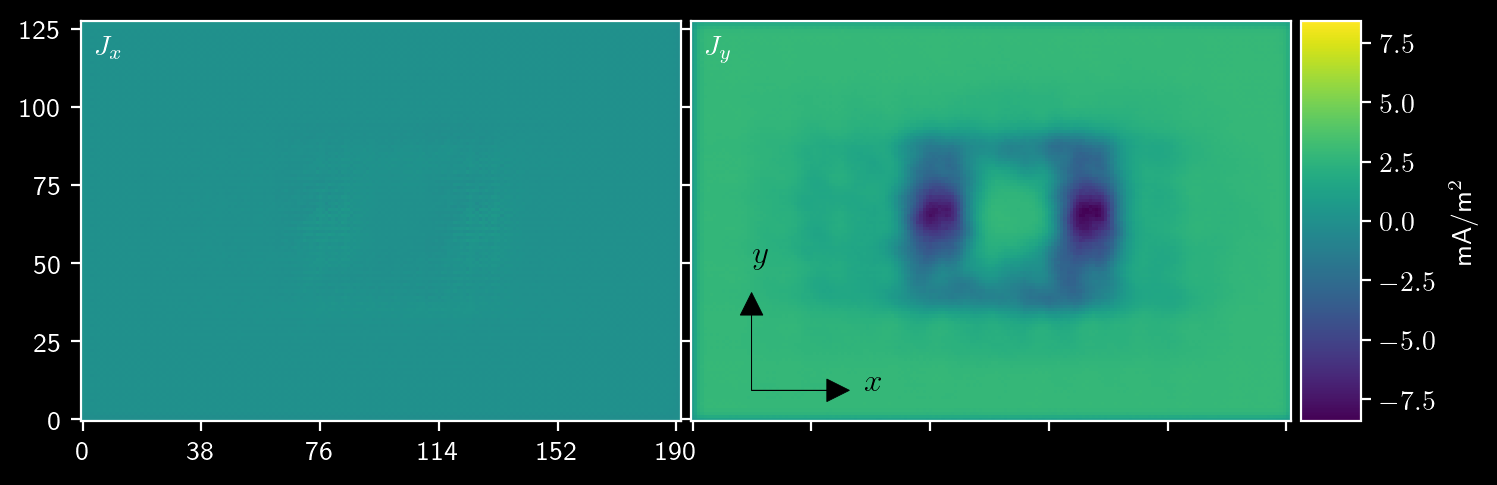

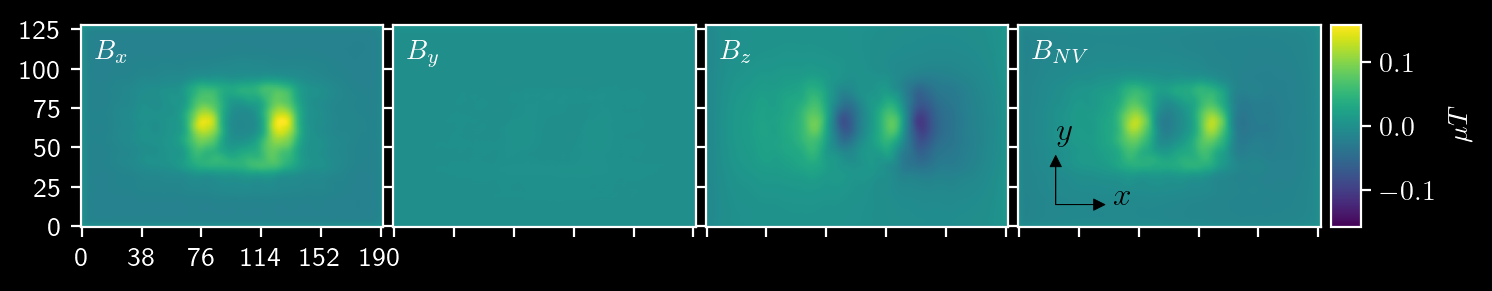

tensor([[[[ 9.9889e-03,  7.1284e-03,  3.7666e-03,  ...,  3.9162e-03,
            6.9568e-03,  9.8817e-03],
          [ 8.7852e-03,  5.5000e-03,  1.8039e-03,  ...,  2.0179e-03,
            5.3789e-03,  8.6994e-03],
          [ 6.2751e-03,  2.3017e-03, -2.1648e-03,  ..., -1.9280e-03,
            2.1140e-03,  6.1507e-03],
          ...,
          [ 4.4315e-03,  7.3808e-05, -5.0238e-03,  ..., -5.0865e-03,
           -5.4214e-04,  4.0208e-03],
          [ 6.5511e-03,  2.7677e-03, -1.7881e-03,  ..., -1.8718e-03,
            2.1491e-03,  6.1396e-03],
          [ 8.7529e-03,  5.6210e-03,  1.7775e-03,  ...,  1.7928e-03,
            5.2380e-03,  8.5190e-03]]]], grad_fn=<SliceBackward0>)

In [28]:
recon.propagate(B, epochs=200, print_log_every=20, callbacks__print_log__floatfmt=".2e", lr=1)

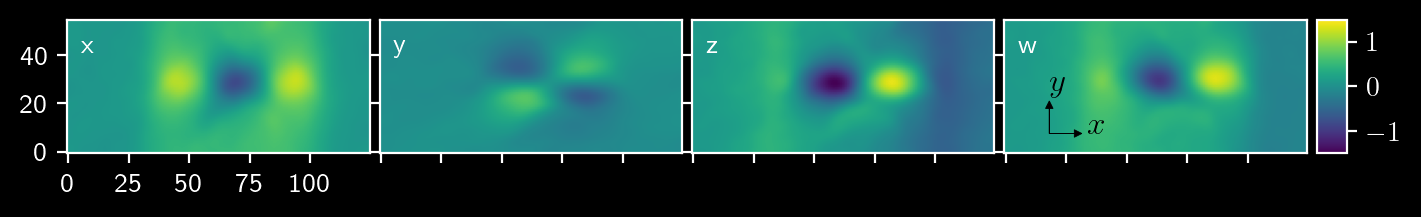

In [29]:
padder = Padder(up_to=(16*12, 16*8))

pipe = Pipe([
    ('gaussian_filter', GaussianFilter(2.0)),
    ('plot1', PlotResults()),
    ('B_NV', Function(lambda x: x[None, 0:1, :, :])),
    ('padded_B_NV', padder),
])

pipe.fit(B).transform(B);

padding = padder.padding
threshold = -0.2
mask = torch.where(B.abs()[0] > threshold, torch.ones_like(B[0]), torch.zeros_like(B[0]))
mask = torch.nn.functional.pad(mask, (padding[-1], padding[-2], 0, 0), mode='constant', value=1.0)
mask = torch.nn.functional.pad(mask, (0, 0, padding[-3], padding[-4]), mode='constant', value=0.0)
def apply_mask(x):
    masked_x = mask * x
    return masked_x

mask_fn = Function(apply_mask)

model = Pipe([
    ('plot1', PlotResults(labels=[r"$J_x$", r"$J_y$"], units=r"mA/m$^2$")),
    ('mask', mask_fn),
    ('B', CurrentLayerToField(dx=dx, dy=dy, height=height, layer_thickness=layer_thickness)),
    ('B+B_NV', Union([('B', 'passthrough'), ('B_NV', Projection(theta=theta, phi=phi))], dim=-3)),
    ('plot2', PlotResults(labels=[r"$B_x$", r"$B_y$", r"$B_z$", r"$B_{NV}$"], units=r"$\mu T$")),
    ('B_NV', Function(lambda x: x[..., [-1], :, :])),
])

recon = Prototype(
    net=FCCNN, 
    model=model, 
    pipe=pipe, 
    max_epochs=20, 
    n_channels_in=1, 
    n_channels_out=2
    )

  epoch    train_loss       dur
-------  ------------  --------
   2619      3.51e-03  3.10e-01
   2800      3.49e-03  1.88e-01
   3000      3.48e-03  2.39e-01
   3200      3.46e-03  2.38e-01
   3400      3.45e-03  8.06e-01
   3600      3.43e-03  1.85e-01
   3800      3.42e-03  2.24e-01
   4000      3.40e-03  3.81e-01
   4200      3.39e-03  2.54e-01
   4400      3.38e-03  2.31e-01
   4600      3.36e-03  3.45e-01


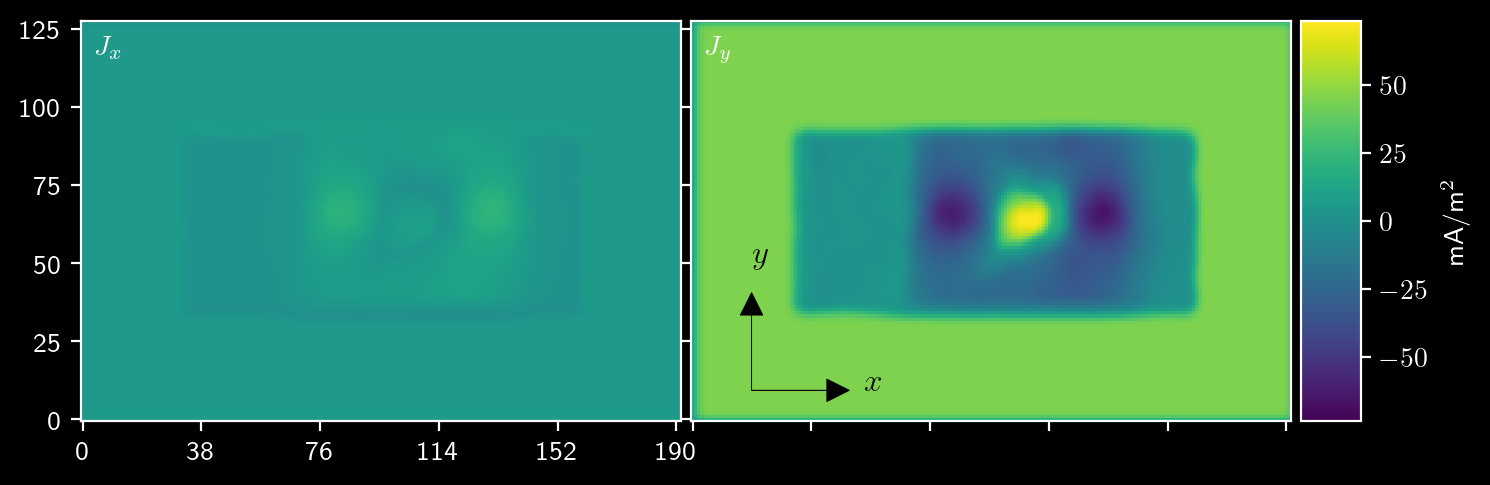

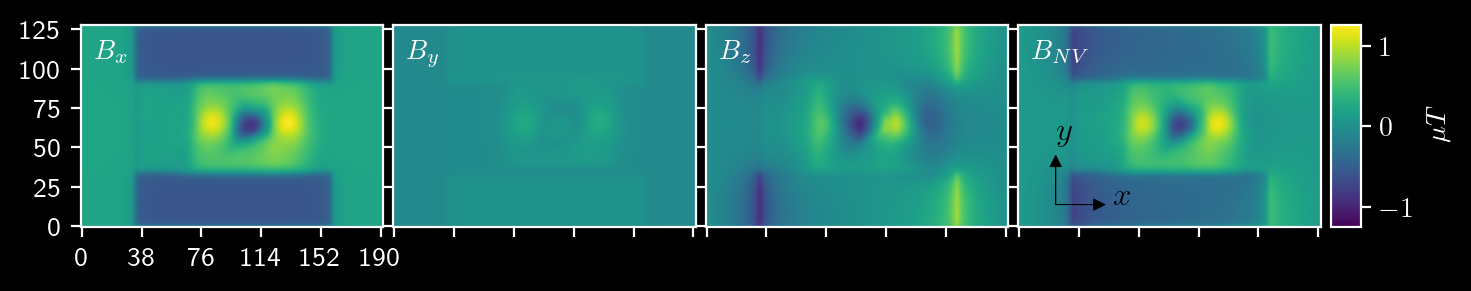

tensor([[[[0.1141, 0.1141, 0.1140,  ..., 0.1142, 0.1142, 0.1141],
          [0.1074, 0.1073, 0.1073,  ..., 0.1075, 0.1074, 0.1074],
          [0.1006, 0.1006, 0.1006,  ..., 0.1007, 0.1007, 0.1007],
          ...,
          [0.1342, 0.1341, 0.1341,  ..., 0.1342, 0.1342, 0.1342],
          [0.1275, 0.1274, 0.1274,  ..., 0.1275, 0.1275, 0.1275],
          [0.1208, 0.1207, 0.1207,  ..., 0.1208, 0.1208, 0.1208]]]],
       grad_fn=<IndexBackward0>)

In [34]:
recon.propagate(B, epochs=2000, print_log_every=200, callbacks__print_log__floatfmt=".2e", lr=0.01)


## Same FCCNN but without the mask

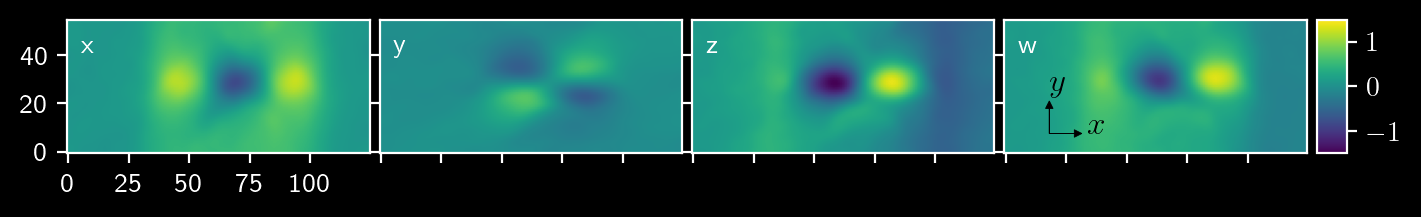

In [38]:
padder = Padder(up_to=(16*12, 16*8))

pipe = Pipe([
    ('gaussian_filter', GaussianFilter(2.0)),
    ('plot1', PlotResults()),
    ('B_NV', Function(lambda x: x[None, 0:1, :, :])),
    ('padded_B_NV', padder),
])

pipe.fit(B).transform(B);

padding = padder.padding
threshold = -0.2
mask = torch.where(B.abs()[0] > threshold, torch.ones_like(B[0]), torch.zeros_like(B[0]))
mask = torch.nn.functional.pad(mask, (padding[-1], padding[-2], 0, 0), mode='constant', value=1.0)
mask = torch.nn.functional.pad(mask, (0, 0, padding[-3], padding[-4]), mode='constant', value=0.0)
def apply_mask(x):
    masked_x = mask * x
    return masked_x

mask_fn = Function(apply_mask)

model = Pipe([
    ('plot1', PlotResults(labels=[r"$J_x$", r"$J_y$"], units=r"mA/m$^2$")),
    # ('mask', mask_fn),
    ('B', CurrentLayerToField(dx=dx, dy=dy, height=height, layer_thickness=layer_thickness)),
    ('B+B_NV', Union([('B', 'passthrough'), ('B_NV', Projection(theta=theta, phi=phi))], dim=-3)),
    ('plot2', PlotResults(labels=[r"$B_x$", r"$B_y$", r"$B_z$", r"$B_{NV}$"], units=r"$\mu T$")),
    ('B_NV', Function(lambda x: x[..., [-1], :, :])),
])

recon = Prototype(
    net=FCCNN, 
    model=model, 
    pipe=pipe, 
    max_epochs=20, 
    n_channels_in=1, 
    n_channels_out=2
    )

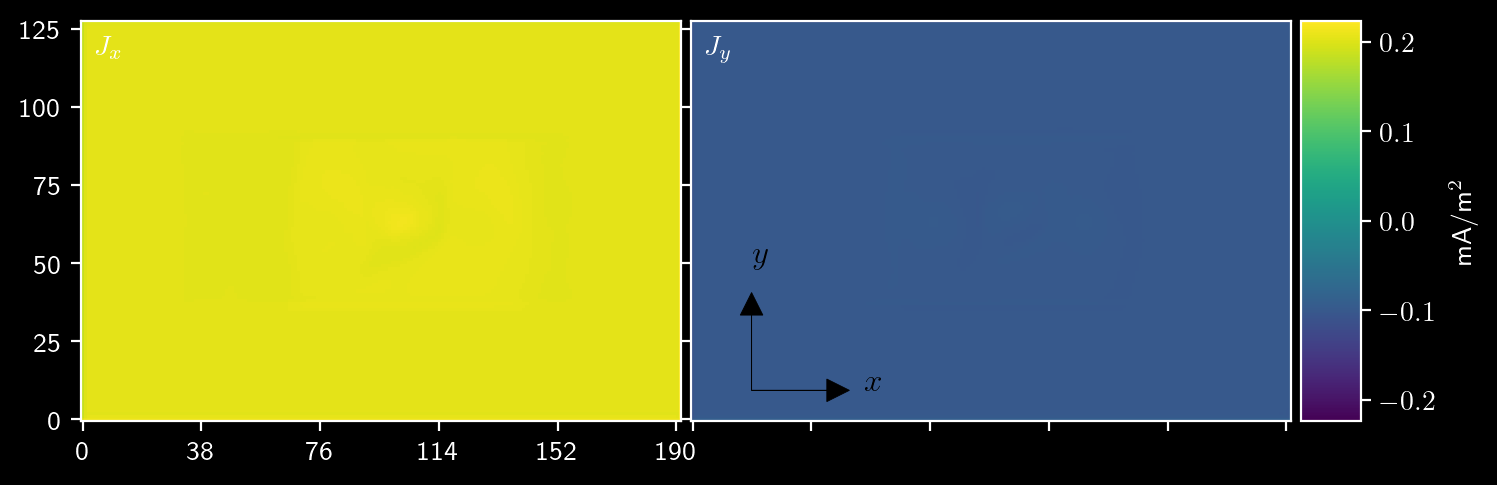

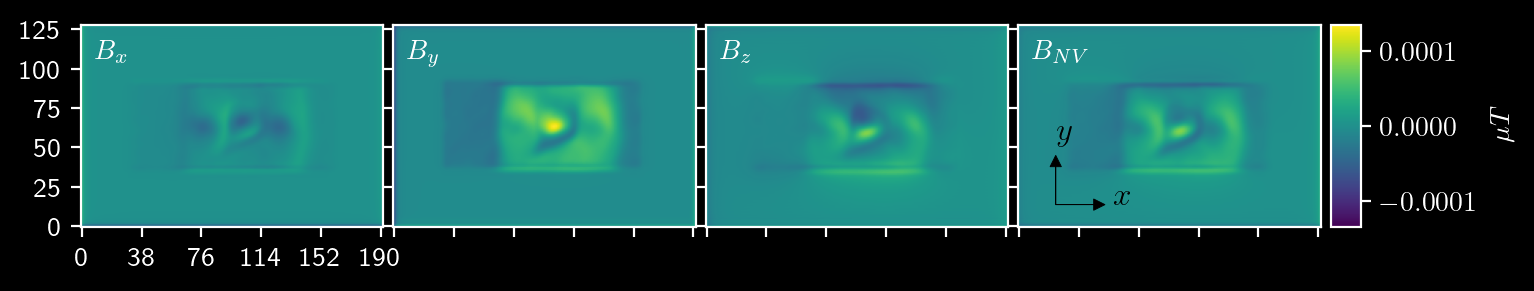

tensor([[[[-1.5163e-06, -1.2767e-05, -1.9752e-06,  ..., -1.6170e-06,
            2.8867e-07,  1.4381e-05],
          [-1.3538e-05, -2.9958e-05, -1.8717e-05,  ..., -1.9090e-05,
           -1.7244e-05,  5.2357e-06],
          [-1.2809e-05, -2.8463e-05, -1.6830e-05,  ..., -1.8927e-05,
           -1.7926e-05,  5.1210e-06],
          ...,
          [ 1.8725e-06, -6.5775e-06,  6.9350e-06,  ...,  1.8504e-06,
           -5.4997e-07,  1.7483e-05],
          [ 2.9246e-06,  8.0761e-07,  1.4573e-05,  ...,  1.1299e-05,
            1.0177e-05,  2.2842e-05],
          [ 7.7018e-06,  8.1240e-06,  2.0642e-05,  ...,  1.9797e-05,
            2.0928e-05,  2.8718e-05]]]], grad_fn=<IndexBackward0>)

In [39]:
recon.propagate(B, epochs=0, print_log_every=20, callbacks__print_log__floatfmt=".2e", lr=0.1)
